# 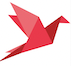 
# Build a TF model on private census with Sarus

### In this tutorial for **Data Scientists**, you will see how to:

1. Connect to Sarus gateway and see available datasets
2. Analyze the private data as a pandas dataframe
3. Preprocess the remote private data
4. Train a TF model onto the remote real data

In [1]:
%%capture
!pip install sarus

In [2]:
from sarus import Client
client = Client(url='https://demo.sarus.tech:5000', email='demo.user@sarus.tech', password='Demo1')
# Here, you can use our demo credentials or your own ones!

In [3]:
client.list_datasets()

[<Sarus Dataset slugname=imdb_reviews id=15>,
 <Sarus Dataset slugname=patient_data id=14>,
 <Sarus Dataset slugname=private_census id=13>]

In [4]:
# Select a dataset among the ones you've been granted access to: the census one
remote_dataset = client.dataset(slugname="private_census")

In [5]:
# We can explore the remote data as a pandas dataframe
dataframe = remote_dataset.as_pandas()
dataframe.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,31,Private,365752,Bachelors,13,Married-civ-spouse,Handlers-cleaners,Husband,White,Female,0,1707,55,United-States,>50K
1,46,Private,256057,Some-college,11,Married-civ-spouse,Exec-managerial,Not-in-family,White,Male,8614,0,50,United-States,<=50K
2,34,Private,128458,Masters,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,40,Federal-gov,357937,12th,9,Divorced,Sales,Husband,White,Male,0,0,45,United-States,>50K
4,28,Self-emp-not-inc,309187,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,1977,60,Holand-Netherlands,<=50K


In [6]:
dataframe.mean()

/opt/conda/lib/python3.8/site-packages/sarus/pandas/dataframe.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return super().mean(axis, skipna, level, numeric_only, **kwargs)


age                   42.366073
fnlwgt            187220.537107
education_num         10.903381
capital_gain        9650.316663
capital_loss         547.456274
hours_per_week        42.942365
dtype: float64

In [7]:
import tensorflow as tf

def preprocess(batch):
    X = tf.stack([batch["age"], batch["education_num"], batch["hours_per_week"]], axis=1)
    X = tf.nn.relu(X)  # Replace encoded NaN by 0
    y = batch["income"]
    return X, y

In [8]:
tf_ds = remote_dataset.as_tensorflow().batch(16).map(preprocess)

In [9]:
from sarus.tensorflow import Model # Only changing the import line!

from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

class DNN(Model): 
    def __init__(self):
        super().__init__()
        self.dense = Dense(units=10)
        self.dense2 = Dense(units=2)

    def call(self, x, training=False):
        return self.dense2(tf.nn.relu(self.dense(x)))

model = DNN()

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["sparse_categorical_accuracy"],
)

In [10]:
model.fit(tf_ds, epochs=2, target_epsilon=1)

Epoch 1/2
312/312 [==============================] - 1s 888us/step - loss: 5.8075 - sparse_categorical_accuracy: 0.4489
Epoch 2/2
312/312 [==============================] - 0s 864us/step - loss: 5.0335 - sparse_categorical_accuracy: 0.4515

